# South African Language Identification Hack

© Explore Data Science Academy

---
### Honour Code

I, **Mekayle Rajoo**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: South African Language Identification Hack

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.
From South African Government.

With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a href=#eight>8.  Predicting on Unseen Data</a>

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
import numpy as np
import pandas as pd
import spacy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from sklearn.feature_selection import VarianceThreshold
import string


import matplotlib.style as style
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
# NLTK - Natural Language Toolkit
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import re


# set plot style
sns.set()

from collections import Counter
# In anaconda prompt, type 'conda install -c conda-forge wordcloud=1.8.1'
from wordcloud import WordCloud
# In anaconda prompt, type 'conda install -c conda-forge spacy'
# followed by 'python -m spacy download en_core_web_sm'
# spaCy is a library for advanced natural language processing in Python
import spacy
nlp = spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings("ignore")

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [2]:
df = pd.read_csv("train_set.csv")
df.head(10)

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
5,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga ...
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [3]:
df.tail()

,lang_id,text
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999,sot,mafapha a mang le ona a lokela ho etsa ditlale...


The dimentionality of our data:

In [4]:
df.shape

(33000, 2)

Overview of the index dtype and columns, non-null values and memory usage:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


To confirm there is no missing data: 

In [6]:
df.isnull().sum()

lang_id    0
text       0
dtype: int64

Lets confirm that all 11 official languages are present:

In [7]:
lang_type = list(df.lang_id.unique())
print(lang_type,"\n\n", len(lang_type), "languages")

['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr'] 

 11 languages


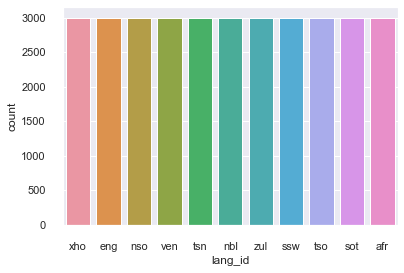

In [8]:
style.use('seaborn-bright')

sns.countplot(df["lang_id"], order = df["lang_id"].value_counts().index)


plt.show()

In [9]:
df["lang_id"].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

We can clearly see that our data is perfecly balanced, as all things should be. 

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

1)  First, we convert all text to lowercase, making our data more consistent and ensuring our model doesn't differentiate between identical words such as "Computer" and "computer". 

In [10]:
df['text'] = df['text'].str.lower()

2) Punctuation removal will help us to treat each text value equally. For example, the word "data" and "data!" are treated equally after the process of removal of punctuations. Also punctuation such as $%&'()*+,-./:;<=>?@[\]^_`{|}~ will not be valuable when trying to predict a language as they are common to all 11 languages. 

In [11]:
def remove_punctuation(message):
    return ''.join([l for l in message if l not in string.punctuation])

In [12]:
df["text"] = df["text"].apply(remove_punctuation)

3) Upon viewing the data in the text column we notice that there are some characters which, in terms of language, do not make sense. We therefore remove these

In [13]:
non = list({'\x81','\x82','\x83','\x84','\x88','\x8f','\x90','\x92','\x9f','¢','£','¥','¦','©','¬','¯','°','±','²','³','´','·',
       '¸','¹','º','¼','½','¿','à','ƒ','˜','—','‚','†','€','™','●'})

In [14]:
def remover(string):  #splits the string into a list and searches for words that contain these characters and removes them. 
    split = string.split(" ")  
    for word in split:
        for letter in word:
            if letter in non:
                string = string.replace(word,"")
                
    
    return string.strip()


In [15]:
df["text"] = df["text"].apply(remover)

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

First we separate our data into the feature and labels:

In [16]:
x = df["text"]
y = df["lang_id"]

Next we Vectorize our data, i.e., transform sentences into arrays of numbers. We opt for the TfidfVectorizer() over CountVectorizer() due to it not only focusing on the frequency of words present in the corpus but also providing the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

In [17]:
tv = TfidfVectorizer(min_df = 2, max_df = 0.5)
# the min_df parameter ensures that we do not consider words that occur only once and the max_df parameter removes words that
# appear in more than 50% of our data. 
xtv = tv.fit_transform(x) 

We then create our train-test split, define the models we want to create and then train these models. 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(xtv, y, test_size=0.2, random_state=42)

Logistic Regression:

In [19]:
lm = LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression()

Linear Support Vector Classifier:

In [20]:
svc = SVC(kernel = "linear")
svc.fit(X_train, y_train)

SVC(kernel='linear')

K-nearest neighbours:

In [21]:
n_neighbors = 8

knn = KNeighborsClassifier(n_neighbors)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

Multinomial Naive Bayes Classifier:

In [22]:
mnbc = MultinomialNB(alpha=5)
mnbc.fit(X_train, y_train)

MultinomialNB(alpha=5)

Decision Tree:

In [23]:
tree = DecisionTreeClassifier(max_depth=25)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=25)

Random Forest:

In [24]:
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)

Ada Boost Classifier:

In [25]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

AdaBoostClassifier()

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [26]:
def scores(lm, X_test, y_test):
    # your code here
    accuracy = accuracy_score(y_test, lm.predict(X_test) )
    precision = precision_score(y_test, lm.predict(X_test), average = "weighted" )
    recall = recall_score(y_test, lm.predict(X_test), average = "weighted" )
    f = f1_score(y_test, lm.predict(X_test), average = "weighted" ) 
    return {"Accuracy": round(accuracy,5), "Precision":round(precision,5), "Recall": round(recall,5), "f1": round(f,5)}

In [27]:
models = [lm, svc, knn, mnbc, tree, forest, abc] #List of our models and below are their full names. 

model_names = ["Logistic Regression", "Linear Support Vector Classifier", "K Nearest Neighbours",
                   "Multinomial Naive Bayes Classifier", "Decision Tree", "Random Forest", "AdaBoostClassifier" ] 

f1_scores = [] #We store the f1 scores so we can plot them later on for comparison. 
for i in range(len(models)):
    all_scores = scores(models[i], X_test, y_test)
    f1 = f1_scores.append(list(all_scores.items())[3][1])
    print(model_names[i],": ", all_scores)
    print("")

Logistic Regression :  {'Accuracy': 0.99485, 'Precision': 0.99487, 'Recall': 0.99485, 'f1': 0.99485}

Linear Support Vector Classifier :  {'Accuracy': 0.99606, 'Precision': 0.99607, 'Recall': 0.99606, 'f1': 0.99606}

K Nearest Neighbours :  {'Accuracy': 0.9747, 'Precision': 0.97506, 'Recall': 0.9747, 'f1': 0.97461}

Multinomial Naive Bayes Classifier :  {'Accuracy': 0.99727, 'Precision': 0.99728, 'Recall': 0.99727, 'f1': 0.99727}

Decision Tree :  {'Accuracy': 0.88818, 'Precision': 0.921, 'Recall': 0.88818, 'f1': 0.89391}

Random Forest :  {'Accuracy': 0.10318, 'Precision': 0.69946, 'Recall': 0.10318, 'f1': 0.04468}

AdaBoostClassifier :  {'Accuracy': 0.58, 'Precision': 0.62561, 'Recall': 0.58, 'f1': 0.52437}



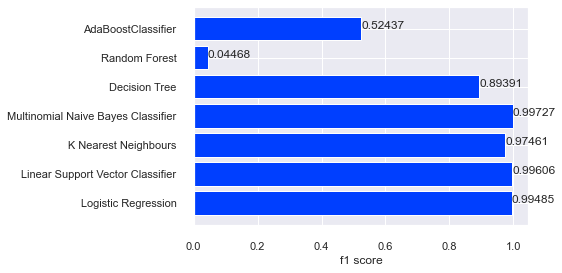

In [28]:
ax = plt.subplot(111)
ax.barh(model_names, f1_scores)
ax.set_xlabel("f1 score")
for index, value in enumerate([round(value,5) for value in f1_scores]):
    ax.text(value, index, str(value))

We see that our best performing model is the Multinomial Naive Bayes Classifier. We will now try to optimize these models by performing a Grid Search on both of them.

In [29]:
param_grid = {'alpha': [0.1, 1, 5, 10]}
best_mnbc = GridSearchCV(MultinomialNB(),param_grid=param_grid,cv=5,n_jobs=-1,scoring='f1_weighted')

In [30]:
best_mnbc.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 5, 10]}, scoring='f1_weighted')

In [31]:
scores(best_mnbc, X_test, y_test)

{'Accuracy': 0.99879, 'Precision': 0.99879, 'Recall': 0.99879, 'f1': 0.99879}

In [32]:
best_mnbc.best_params_

{'alpha': 1}

Hence, our best performing model is a Multinomial Naive Bayes Theorem with an Alpha value of 1. 

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

As mentioned above, our best performing model was a Multinomial Naive Bayes Theorem with an Alpha value of 1, but how exactly does this model work ? 

Naive Bayes is a classification algorithm that uses the principle of Bayes theorem (describes the probability of an event, based on prior knowledge of conditions that might be related to the event.) to make classifications.

We use the Multinomial variant of the Naive Bayes Classifier as it performs well when used for discrete data such as language.
Here we consider bernoulli trials which you can think of as the number of times outcome number x_i is observed over the n trials 

<a id="eight"></a>
## 8. Predicting on Unseen Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [33]:
test = pd.read_csv("test_set.csv")
test.head(10)

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.
5,6,"Ke feela dilense tše hlakilego, tša pono e tee..."
6,7,<fn>(762010101403 AM) 1495 Final Gems Birthing...
7,8,Ntjhafatso ya konteraka ya mosebetsi: Etsa bon...
8,9,u-GEMS uhlinzeka ngezinzuzo zemithi yezifo ezi...
9,10,"So, on occasion, are statistics misused."


In [34]:
def cleaning(data, model):
    
    df = data.copy()
    df['text'] = df['text'].str.lower()
    df["text"] = df["text"].apply(remover)
    
    x = df["text"]
    xtr = tv.transform(x)
    y_pred = {"lang_id":model.predict(xtr)}
    
    sub = pd.DataFrame(y_pred)
    
    sub.index = np.arange(1, len(sub)+1)
    sub.index.name = 'index'
    
    return sub

In [35]:
cleaning(test,best_mnbc).to_csv("Final_Submission.csv")